In [1]:
import os

import gym
import numpy as np
import pandas as pd
import seaborn as sns

from ray import init, rllib, tune, shutdown

In [2]:
from attack_simulator.agents import DEFENDERS
from attack_simulator.env import AttackSimulationEnv
from attack_simulator.graph import AttackGraph, SIZES

In [3]:
class AgentPolicy(rllib.policy.Policy):
    def __init__(self, observation_space, action_space, config):
        super().__init__(observation_space, action_space, config)
        agent_config = dict(
            input_dim=observation_space.shape[0],
            num_actions=action_space.n,
            random_seed=config["seed"],
            attack_graph=config["env_config"]["attack_graph"],
        )
        self._agent = DEFENDERS[config["agent_type"]](agent_config)

    def compute_actions(self, observations, *args, **kwargs):
        # FIXME: use a `numpy` array as a temporary workaround for
        #        https://github.com/ray-project/ray/issues/10100
        return np.array([self._agent.act(obs) for obs in observations]), [], {}

    def get_weights(self):
        return {}

    def set_weights(self, weights):
        pass


def template_agent(agent_type):
    default_config = rllib.agents.trainer.with_common_config(dict(agent_type=agent_type))
    return rllib.agents.trainer_template.build_trainer(
        name=agent_type,
        default_policy=AgentPolicy,
        default_config=default_config,
    )

In [4]:
from copy import deepcopy

class AttackSimAlphaZeroEnv(AttackSimulationEnv):
    def set_state(self, state):
        (
            self.simulation_time,
            self.ttc_remaining,
            self.attack_surface,
            self.attack_state,
            self.service_state,
            self._observation,
        ) = deepcopy(state)

    def get_state(self):
        state = (
            self.simulation_time,
            self.ttc_remaining,
            self.attack_surface,
            self.attack_state,
            self.service_state,
            self._observation,
        )
        return deepcopy(state)
    

class AlphaZeroWrapper(gym.Env):
    def __init__(self, config):
        self.env = config["env_class"](config)
        self.action_space = self.env.action_space
        assert isinstance(
            self.action_space, gym.spaces.Discrete
        ), "AlphaZero requires a Discrete action space"
        shape = (self.action_space.n,)
        self.observation_space = gym.spaces.Dict(
            dict(obs=self.env.observation_space, action_mask=gym.spaces.Box(0, 1, shape))
        )
        self.reward = 0
        self.mask = np.full(shape, 1, dtype="int8")

    def reset(self):
        self.reward = 0
        observation = self.env.reset()
        return dict(obs=observation, action_mask=self.mask)

    def step(self, action):
        observation, reward, done, info = self.env.step(action)
        self.reward += reward
        reward = self.reward if done else 0
        return dict(obs=observation, action_mask=self.mask), reward, done, info

    def set_state(self, state):
        env_state, self.reward = state
        self.env.set_state(env_state)
        return dict(obs=self.env.observation, action_mask=self.mask)

    def get_state(self):
        return self.env.get_state(), self.reward

    def close(self):
        self.env.close()

    def render(self, mode=None):
        self.env.render(mode)

    def seed(self, seed=None):
        self.env.seed(seed)

In [5]:
# 'contrib/AlphaZero' does NOT appear to work without its custom dense model
from ray.rllib.contrib.alpha_zero.models.custom_torch_models import DenseModel

rllib.models.ModelCatalog.register_custom_model("alpha_zero_dense_model", DenseModel)

In [6]:
import pandas as pd


class RolloutAggregator:
    def __init__(self, **kwargs):
        self._kwargs = kwargs
        self._episodes = []

    def begin_rollout(self):
        self._rewards = []

    def append_step(self, obs, action, next_obs, reward, done, info):
        self._rewards.append(reward)

    def end_rollout(self):
        self._episodes.append(
            dict(self._kwargs, episode_length=len(self._rewards), episode_reward=sum(self._rewards))
        )

    def to_df(self):
        return pd.DataFrame(self._episodes)

In [7]:
if os.path.isdir("/var/run/secrets/kubernetes.io"):  # inside k8s pod
    args = dict(address="auto")
else:
    # listen on all interfaces inside a container for port-forwarding to work
    dashboard_host = "0.0.0.0" if os.path.exists("/.dockerenv") else "127.0.0.1"
    args = dict(num_cpus=4, dashboard_host=dashboard_host)

# ALTERNATIVE: use the "Ray client" to connect to a remote cluster
# Unfortunately, JupyterNotebookReporter displays an object reference
# <IPython.core.display.HTML object> instead of content...
# --- --- ---
#
# from ray.util.client import worker
#
# worker.INITIAL_TIMEOUT_SEC = worker.MAX_TIMEOUT_SEC = 1
#
# ray_client_server = 'host.docker.internal' if os.path.exists("/.dockerenv") else '127.0.0.1'
# try:
#     init(address=f'ray://{ray_client_server}:10001')
# except Connection Error:
#     pass  # TODO: try something else...

In [8]:
from ray.rllib.rollout import rollout
from ray.tune.utils.trainable import TrainableUtil
from tqdm import tqdm

rename = dict(
    agent_type="Agent",
    graph_size="Graph size",
    episode_length="Episode lengths",
    episode_reward="Returns",
)
# FIXME: temporarily omit "contrib/AlphaZero" due to https://github.com/ray-project/ray/issues/13177
# agent_types = ["contrib/AlphaZero", "R2D2", "rule-based", "random"]
agent_types = ["R2D2", "rule-based", "random"]
seeds = [0, 1, 2, 3, 6, 7, 11, 28, 42, 1337]
iterations = 10
rollouts = 10


def generate(savename):
    init(**args)
    
    frames = []
    for graph_size in SIZES:
        graph = AttackGraph(dict(graph_size=graph_size))

        for agent_type in agent_types:
            for seed in seeds:
                config = dict(
                    framework="torch",
                    model=dict(use_lstm=True),
                    env=AttackSimulationEnv,
                    env_config=dict(attack_graph=graph),
                    seed=seed,
                    create_env_on_driver=True,  # apparently, assumed by `rollout`
                    num_workers=4,
                    batch_mode="complete_episodes",
                    # log_level='DEBUG',
                )
                if agent_type in DEFENDERS:
                    agent = template_agent(agent_type)(config=config)
                else:
                    if agent_type == "contrib/AlphaZero":
                        config["env_config"].update(env_class=AttackSimAlphaZeroEnv)
                        config.update(
                            env=AlphaZeroWrapper,
                            model=dict(custom_model="alpha_zero_dense_model"),
                            rollout_fragment_length=32,
                            train_batch_size=1280,
                            sgd_minibatch_size=64,
                        )
                    agent = rllib.agents.registry.get_trainer_class(agent_type)(config=config)
                    name = f'{agent_type.split("/")[-1]}_{graph_size}_{seed}'
                    if os.path.exists(name):
                        checkpoint_path = TrainableUtil.get_checkpoints_paths(name).chkpt_path[0]
                        agent.restore(checkpoint_path)
                    else:
                        pbar = tqdm(range(iterations), name)
                        for _ in pbar:
                            results = agent.train()
                            # TODO: break based on results?
                        agent.save(name)

                aggregator = RolloutAggregator(agent_type=agent_type, graph_size=graph.num_attacks)
                rollout(agent, "AttackSim", num_steps=0, num_episodes=rollouts, saver=aggregator)
                frames.append(aggregator.to_df())
    shutdown()
    results_df = pd.concat(frames, ignore_index=True).rename(columns=rename)
    results_df.to_csv(savename)
    return results_df

In [9]:
%%capture noise --no-stderr

savename = "returns-rollout.csv"

df = generate(savename) if not os.path.exists(savename) else pd.read_csv(savename, index_col=0)

In [10]:
df

,Agent,Graph size,Episode lengths,Returns
0,R2D2,7,76,150
1,R2D2,7,135,268
2,R2D2,7,8,15
3,R2D2,7,146,-16704
4,R2D2,7,138,-13280
...,...,...,...,...
2095,random,78,14,155
2096,random,78,9,108
2097,random,78,23,177
2098,random,78,27,184


In [11]:
sns.set(style="darkgrid", rc={"figure.figsize": (12, 8)})

Text(0.5, 1.0, 'Returns vs Size (random attacker)')

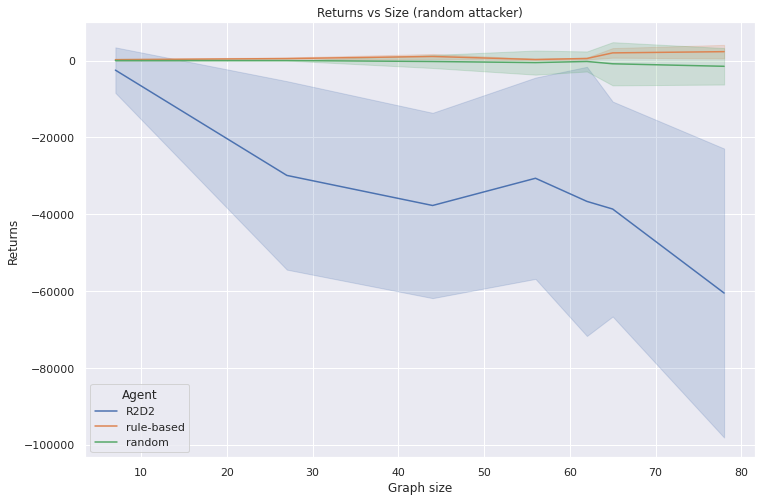

In [12]:
g = sns.lineplot(data=df, x="Graph size", y="Returns", hue="Agent", ci="sd")
g.legend(title="Agent", loc="lower left")
g.set_title("Returns vs Size (random attacker)")

Text(0.5, 1.0, 'Episode lengths vs Size (random attacker)')

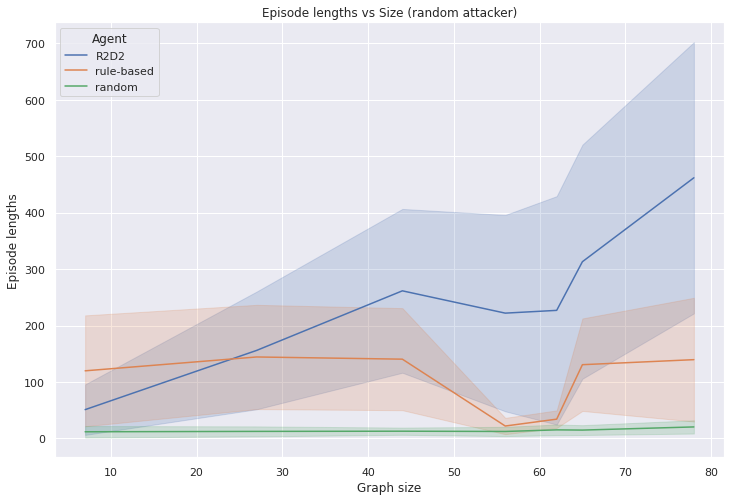

In [13]:
g = sns.lineplot(data=df, x="Graph size", y="Episode lengths", hue="Agent", ci="sd")
g.legend(title="Agent", loc="upper left")
g.set_title("Episode lengths vs Size (random attacker)")

In [14]:
pd.set_option("display.max_columns", 32)
df.groupby("Agent").describe()

Graph size                                                     \
                count       mean        std  min   25%   50%   75%   max   
Agent                                                                      
R2D2            700.0  48.428571  22.649012  7.0  27.0  56.0  65.0  78.0   
random          700.0  48.428571  22.649012  7.0  27.0  56.0  65.0  78.0   
rule-based      700.0  48.428571  22.649012  7.0  27.0  56.0  65.0  78.0   

           Episode lengths                                                    \
                     count        mean         std  min    25%    50%    75%   
Agent                                                                          
R2D2                 700.0  241.691429  207.865201  3.0  75.75  195.5  335.0   
random               700.0   14.177143    9.583608  3.0   7.00   12.0   18.0   
rule-based           700.0  104.347143   94.075934  6.0  35.00   76.0  148.0   

                   Returns                                                  \
               max   count          mean           std       min       25%   
Agent                                                                        
R2D2        1167.0   700.0 -33796.964286  31751.125270 -159211.0 -51415.75   
random        62.0   700.0   -469.991429   3268.863873  -41127.0     10.00   
rule-based   712.0   700.0    999.892857   1169.853377      19.0    287.00   

                                       
                50%      75%      max  
Agent                                  
R2D2       -26337.5 -6878.25    891.0  
random         58.0   113.00    300.0  
rule-based    578.5  1259.00  11470.0